In [1]:
#install libraries

!rm -r kdg
!git clone -b weighted_kdn https://github.com/NeuroDataDesign/kdg
!ls
!pip install kdg/.

rm: cannot remove 'kdg': No such file or directory
Cloning into 'kdg'...
remote: Enumerating objects: 5974, done.
remote: Counting objects: 100% (2875/2875), done.
remote: Compressing objects: 100% (2520/2520), done.
remote: Total 5974 (delta 787), reused 2365 (delta 353), pack-reused 3099
Receiving objects: 100% (5974/5974), 209.12 MiB | 32.41 MiB/s, done.
Resolving deltas: 100% (1742/1742), done.
kdg  sample_data
Processing ./kdg
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 14.5 MB 34 kB/s 
     |████████████████████████████████| 23.2 MB 44.0 MB/s 
  Created wheel for kdg: filename=kdg-0.0.1-py3-none

In [1]:
# import modules
import numpy as np
from numpy.random import default_rng
from sklearn.ensemble import RandomForestClassifier as rf 
from kdg.kdf import *
from kdg.utils import gaussian_sparse_parity, trunk_sim
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
distances = [0.01, 0.1, 1, 2, 5]
n_test = 10
for d in distances:
  print(d)
  rand_dist = rng.random((n_test, p_star))
  rand_dist = np.sqrt(d**2*(rand_dist/np.sum(rand_dist, axis=1)[:,None]))
  #print(rand_dist)
  print(np.sqrt(np.sum(rand_dist**2, axis=1)))

0.01
[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
0.1
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
1
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
2
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
5
[5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]


In [2]:
# define the experimental setup
p = 20 # total dimensions of the data vector
p_star = 3 # number of signal dimensions of the data vector
'''sample_size = np.logspace(
        np.log10(10),
        np.log10(5000),
        num=10,
        endpoint=True,
        dtype=int
        )'''
sample_size = 5000 # sample size under consideration
n_test = 500 # test set size
nTrees = 100
compile_kwargs = {
    "n_estimators": nTrees
    }

def get_kdf_weights(X_star, X_, forest):
    polytope_star = np.array(
        [tree.apply(X_star.reshape(1, -1)) for tree in forest.estimators_]
        ).T
    #print(polytope_star.shape)
    predicted_leaf_ids_across_trees = np.array(
        [tree.apply(X_) for tree in forest.estimators_]
        ).T

    matched_samples = np.sum(
        predicted_leaf_ids_across_trees == polytope_star,
        axis=1
    )
    #print(matched_samples)
    idx = np.where(
        matched_samples>0
    )[0]

    #X_star isn't included in X_ so need to scale this manually
    scale = matched_samples[idx]/polytope_star.shape[1]
      
    return np.array(scale)

In [51]:
X, y = gaussian_sparse_parity(
    sample_size,
    p_star=p_star,
    p=p
)

X_test, y_test = gaussian_sparse_parity(
    n_test,
    p_star=p_star,
    p=p
)

#%%
# train Vanilla RF
vanilla_rf = rf(**compile_kwargs).fit(X, y)

# pick a random point from testing data 
rng = default_rng(0)
idx = rng.integers(0, sample_size)
X_star = X[idx]

#generate a bunch of points
#distances = np.logspace(-20, 1, num=22, base=10)
distances = np.linspace(0, 10, num=100)
X_dist_static = {}
X_dist_noisy = {}
for d in distances:
  #print(d)
  rand_dist = rng.random((n_test, p_star))
  rand_dist = np.sqrt((d**2)*(rand_dist/np.sum(rand_dist, axis=1)[:,None]))
  static_noise = X_star[3:] + np.zeros((n_test, p-p_star))
  random_noise = 2*rng.random((n_test,p-p_star))-1
  X_dist_static[d] = np.concatenate((X_star[:3] + rand_dist, static_noise), axis=1)
  X_dist_noisy[d] = np.concatenate((X_star[:3] + rand_dist, random_noise), axis=1)

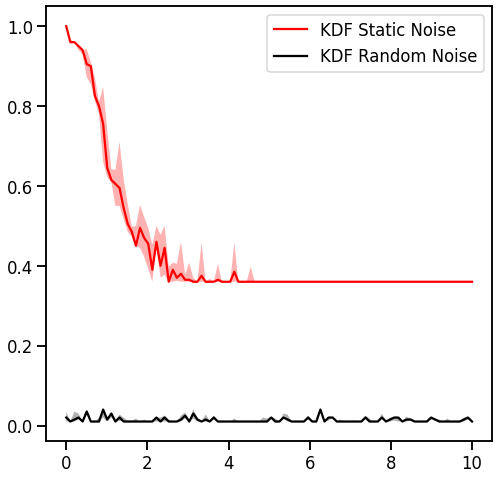

In [52]:
# plot distance vs. weights
weights_s = [get_kdf_weights(X_star, X_dist_static[x], vanilla_rf) for x in X_dist]
weight_med_s = [np.median(w) for w in weights_s]
weight_25q_s = [np.quantile(w, 0.25) for w in weights_s]
weight_75q_s = [np.quantile(w, 0.75) for w in weights_s]

weights_n = [get_kdf_weights(X_star, X_dist_noisy[x], vanilla_rf) for x in X_dist]
weight_med_n = [np.median(w) for w in weights_n]
weight_25q_n = [np.quantile(w, 0.25) for w in weights_n]
weight_75q_n = [np.quantile(w, 0.75) for w in weights_n]

sns.set_context('talk')

fig, ax = plt.subplots(1,1, figsize=(8,8))
#ax.set_xscale("log")
ax.plot(distances, weight_med_s, c="r", label='KDF Static Noise')
ax.plot(distances, weight_med_n, c="k", label='KDF Random Noise')
ax.fill_between(distances, weight_25q_s, weight_75q_s, facecolor='r', alpha=.3)
ax.fill_between(distances, weight_25q_n, weight_75q_n, facecolor='k', alpha=.3)
ax.legend()

In [ ]:
print(f"Mean number of samples per polytopes: {np.mean(RF_weight_sizes)} (range: {np.min(RF_weight_sizes)}, {np.max(RF_weight_sizes)})")
print(f"Mean weight of samples in polytopes: {np.mean(RF_weight_mean):.4f}")
print(f"Median weight of samples in polytopes: {np.median(RF_weight_median)}")

Mean number of samples per polytopes: 325.6078431372549 (range: 17, 431)
Mean weight of samples in polytopes: 0.0160
Median weight of samples in polytopes: 0.004878048780487805
